In [74]:
# import cv2
import numpy as np
# from tqdm import tqdm # progress bar for loops
import os
import tensorflow as tf

DATASET_FOLER = "chest_xray_pneumonia_dataset"
TRAINING_FOLER = DATASET_FOLER + "/" + "trainOG"
TESTING_FOLER = DATASET_FOLER + "/" + "test"
VALIDATION_FOLER = DATASET_FOLER + "/" + "val"
IMAGE_HEIGHT=150
IMAGE_WIDTH=150
COLOR_MODE='grayscale'
IMAGE_CHANNELS = 3 if COLOR_MODE=='rgb' else 1
PATIENCE = 25
EPOCHS = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode=COLOR_MODE,
    seed=42,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TESTING_FOLER,
    batch_size=32,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode=COLOR_MODE,
    seed=42,
)



Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


['NORMAL', 'PNEUMONIA']
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)
(150, 150, 1)


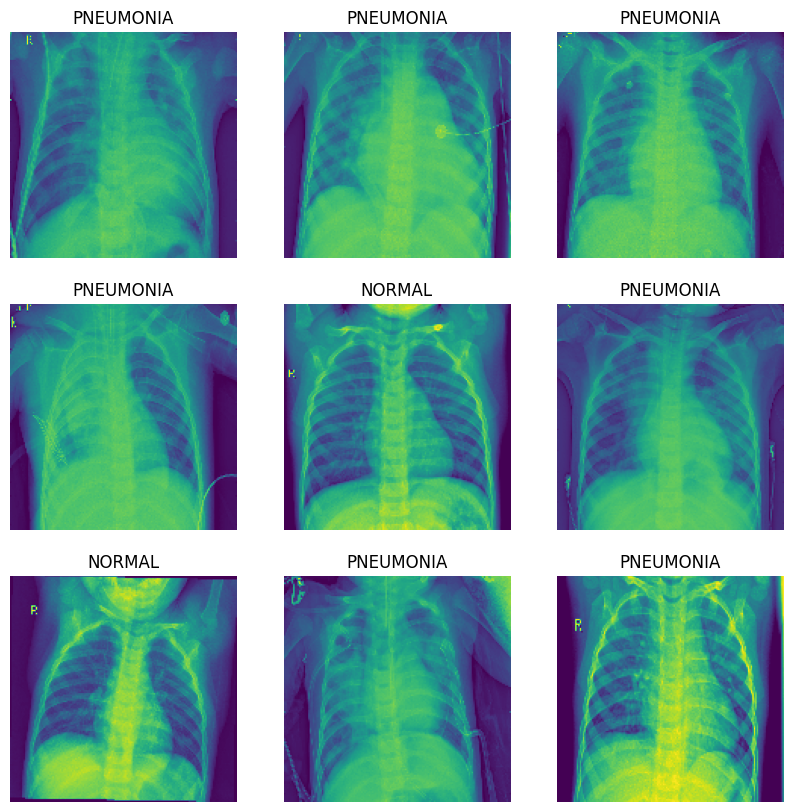

In [75]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [76]:
import tensorflow as tf
from tensorflow import keras

preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
    # tf.keras.layers.CenterCrop(100, 100)
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.2),
    keras.layers.RandomContrast(0.2),
])

train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [77]:
# Calculate class weights
class_counts = train_ds.reduce(
    initial_state=tf.zeros(2), 
    reduce_func=lambda state, batch: state + tf.cast(tf.math.reduce_sum(batch[1], axis=0), tf.float32)
)
total_samples = tf.reduce_sum(class_counts)
class_weights = {0: total_samples / (2 * class_counts[0]), 1: total_samples / (2 * class_counts[1])}


In [78]:
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

# model = Sequential()
# model.add(keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)))
# model.add(preprocessing)

# # model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
# model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# model.add(Flatten())
# model.add(Dense(units = 128 , activation = 'relu'))
# model.add(Dropout(0.2))
# model.add(Dense(units = 1 , activation = 'sigmoid'))
# model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.summary()

In [79]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(None, None, IMAGE_CHANNELS)),

    preprocessing,

    # keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    # keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    # # keras.layers.BatchNormalization(momentum=0.87),
    # keras.layers.MaxPooling2D(),

    # keras.layers.GlobalAveragePooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(1, activation="sigmoid"), #sigmoid is for binary classification
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 150, 150, 1)       0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| resizing_8 (Resizing)     (None, 150, 150, 1)       0         |
|                                                               |
| rescaling_12 (Rescaling)  (None, 150, 150, 1)       0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 conv2d_28 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 75, 75, 32)        0         
                                                     

In [80]:
# train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
# earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=PATIENCE, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[earlystop_loss],
    # class_weight=class_weights,
)

Epoch 1/100
163/163 [==============================] - 16s 88ms/step - loss: 0.5368 - binary_accuracy: 0.7644 - val_loss: 0.5876 - val_binary_accuracy: 0.7901
Epoch 2/100
163/163 [==============================] - 14s 85ms/step - loss: 0.2209 - binary_accuracy: 0.9120 - val_loss: 1.1090 - val_binary_accuracy: 0.7756
Epoch 3/100
163/163 [==============================] - 14s 84ms/step - loss: 0.1390 - binary_accuracy: 0.9459 - val_loss: 0.8311 - val_binary_accuracy: 0.7965
Epoch 4/100
163/163 [==============================] - 14s 85ms/step - loss: 0.1207 - binary_accuracy: 0.9571 - val_loss: 1.0282 - val_binary_accuracy: 0.7580
Epoch 5/100
163/163 [==============================] - 14s 85ms/step - loss: 0.1075 - binary_accuracy: 0.9615 - val_loss: 1.3162 - val_binary_accuracy: 0.7324
Epoch 6/100
163/163 [==============================] - 14s 85ms/step - loss: 0.1039 - binary_accuracy: 0.9620 - val_loss: 0.7976 - val_binary_accuracy: 0.8013
Epoch 7/100
163/163 [=========================

Epochs run: 26


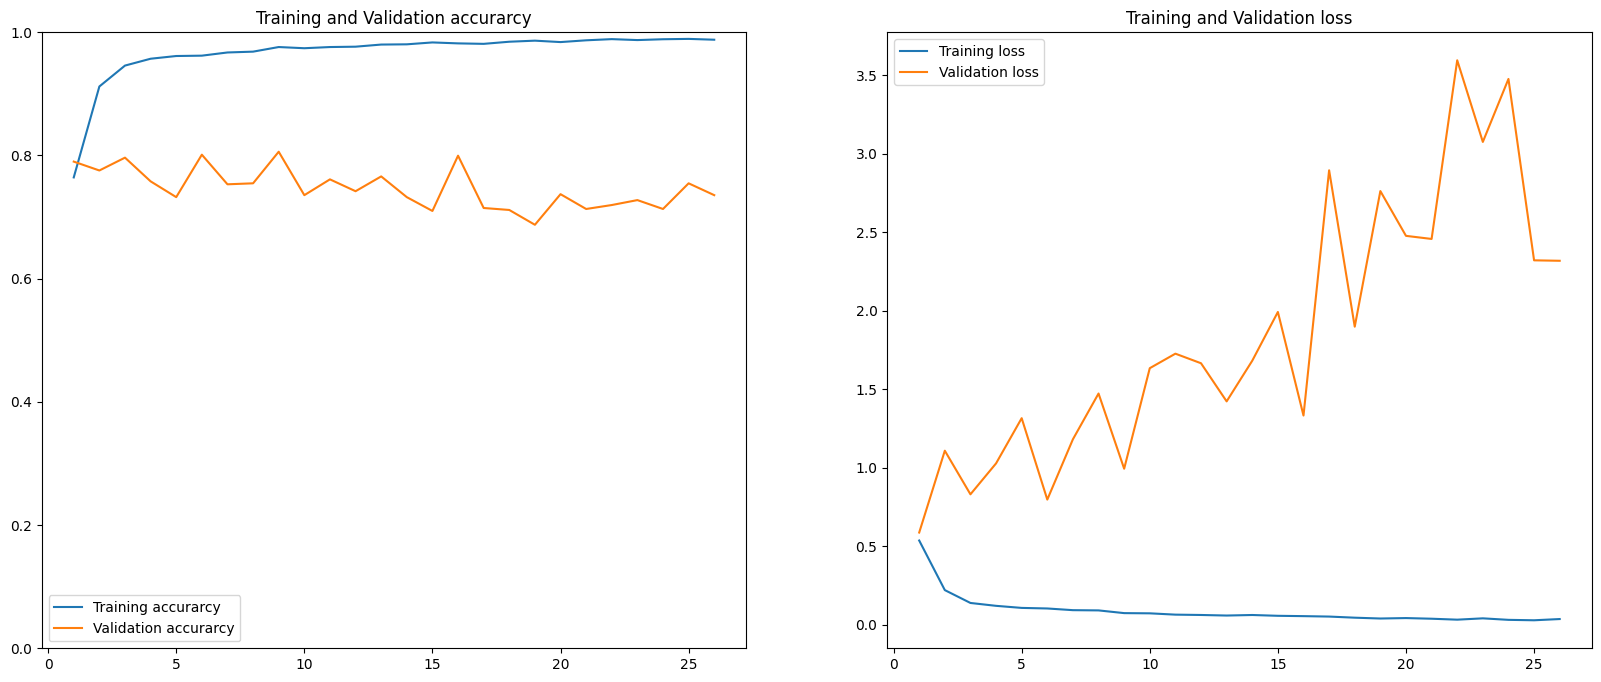

In [81]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["binary_accuracy"]
val_acc = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [82]:
import tensorflow as tf

test_ds = keras.utils.image_dataset_from_directory(TESTING_FOLER,
                                                   color_mode=COLOR_MODE,
                                                   batch_size=32,
                                                   image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                                )


preprocessing = tf.keras.Sequential([
    # tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(1./255),
    # tf.keras.layers.CenterCrop(100, 100)
])

# Preprocess the test dataset
test_ds_preprocessed = test_ds.map(lambda x, y: (preprocessing(x), y))


y_pred = model.evaluate(test_ds, verbose=0)
prediction = model.predict(test_ds)

print("Test accuracy:", y_pred[1]*100)
print("Test loss:", y_pred[0]*100)

Found 624 files belonging to 2 classes.
20/20 [==============================] - 1s 27ms/step
Test accuracy: 79.00640964508057
Test loss: 58.758264780044556


Found 16 files belonging to 2 classes.
1/1 [==============================] - 0s 127ms/step
[[6 2]
 [1 7]]


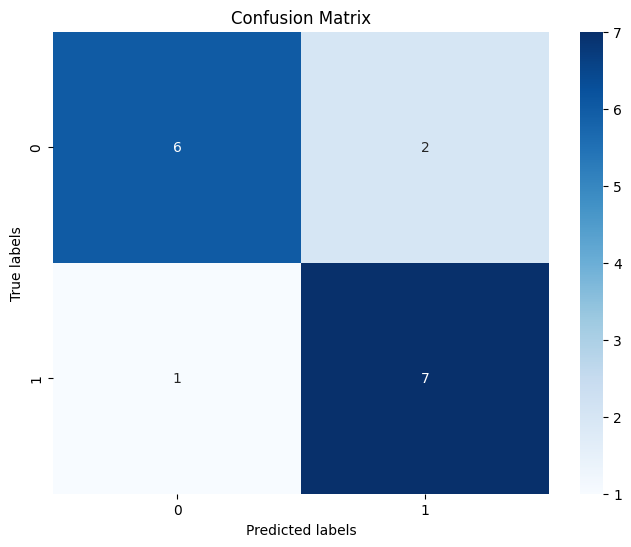

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_FOLER,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=32,
    color_mode=COLOR_MODE,
    shuffle=True,
)

# Get true labels and predicted probabilities
true_labels = []
predicted_probabilities = []

# Iterate over the validation dataset
for images, labels in validation_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_probabilities.extend(predictions)

# Convert probabilities to predicted labels
predicted_labels = np.where(np.array(predicted_probabilities) > 0.5, 1, 0)

# Convert true labels and predicted labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [84]:
# SAVING THE MODEL

# save the iris classification model
model.save("pneumonia-cnn.h5")

In [85]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model("pneumonia-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 


20/20 [==============================] - 1s 36ms/step - loss: 0.5876 - binary_accuracy: 0.7901
